In [2]:
import numpy as np
import mglearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
# http://ai.stanford.edu/~amaas/data/sentiment/
reviews_train = load_files('aclImdb/train')
reviews_test = load_files('aclImdb/test')

In [4]:
text_train, y_train = reviews_train.data, reviews_train.target
print(type(text_train))
print(len(text_train))
print(text_train[1])

<class 'list'>
25000
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one

In [5]:
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]
print('Number of pos/neg reviews: {}'.format(np.bincount(y_train)))
# Balanced dataset

Number of pos/neg reviews: [12500 12500]


In [6]:
text_test, y_test = reviews_test.data, reviews_test.target
print(len(text_test))
print('Number of pos/neg reviews (test): {}'.format(np.bincount(y_test)))
print(text_test[1])
text_test = [doc.replace(b'<br />', b' ') for doc in text_test]

25000
Number of pos/neg reviews (test): [12500 12500]
b'I don\'t know how this movie has received so many positive comments. One can call it "artistic" and "beautifully filmed", but those things don\'t make up for the empty plot that was filled with sexual innuendos. I wish I had not wasted my time to watch this movie. Rather than being biographical, it was a poor excuse for promoting strange and lewd behavior. It was just another Hollywood attempt to convince us that that kind of life is normal and OK. From the very beginning I asked my self what was the point of this movie,and I continued watching, hoping that it would change and was quite disappointed that it continued in the same vein. I am so glad I did not spend the money to see this in a theater!'


**Bag of words** - representation strategy, discards structure in text.
Count how often each word appears in each text in corpus (dataset).

1. Tokenize - split each document into words that appear in it (split on whitespace or punctuation).
2. Build vocabulary - collect all words that appear in all documents and number them.
3. Encode - for each document count how often each word from vocabulary appears in each document.

In [7]:
# Example bag of words
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]
vect = CountVectorizer() # sklearn bag-of-words representation
vect.fit(bards_words) # tokenize and build vocabulary
print('Vocabulary size: {}'.format(len(vect.vocabulary_)))
print('Vocab content: {}'.format(vect.vocabulary_))

Vocabulary size: 13
Vocab content: {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [8]:
bag_of_words = vect.transform(bards_words) # encode to bag of words representation
print(repr(bag_of_words)) # SciPy sparse matrix
bag_of_words.toarray() # convert to array to view content

<2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]])

In [9]:
# Bag of words imdb
vect = CountVectorizer()
vect.fit(text_train) # tokenize and build vocabulary
X_train = vect.transform(text_train) # encode to bag of words representation
print(repr(X_train))

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [10]:
feature_names = vect.get_feature_names() # get vocabulary in form of list
print('Number of features: {}\n'.format(len(feature_names)))
print('First 20 features: {}\n'.format(feature_names[:20]))
print('20010 to 20030 features: {}\n'.format(feature_names[20010:20030]))
print('Every 2000th feature: {}'.format(feature_names[::2000]))

Number of features: 74849

First 20 features: ['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']

20010 to 20030 features: ['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']

Every 2000th feature: ['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [11]:
scores = cross_val_score(LogisticRegression(solver='lbfgs', max_iter=100000), X_train, y_train, cv=5)
print('Mean CV accuracy: {:.2f}'.format(np.mean(scores)))

Mean CV accuracy: 0.88


In [12]:
X_test = vect.transform(text_test)
lr = LogisticRegression(solver='lbfgs', max_iter=100000).fit(X_train, y_train)
print('Test score: {:.2f}'.format(lr.score(X_test, y_test)))

Test score: 0.87


In [13]:
# Tune C
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=100000), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best CV score: 0.89
Best parameters: {'C': 0.1}


In [14]:
X_test = vect.transform(text_test)
print('Test score: {:.2f}'.format(grid.score(X_test, y_test)))

Test score: 0.88


In [15]:
# Set minimum number of documents token needs to appear in
vect = CountVectorizer(min_df=5)

# Tokenize and build vocabulary
vect.fit(text_train)

# Encode
X_train = vect.transform(text_train)
print(repr(X_train))

# Reduced number of features

<25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [16]:
feature_names = vect.get_feature_names()
print('Number of features: {}\n'.format(len(feature_names)))
print('First 20 features: {}\n'.format(feature_names[:20]))
print('20010 to 20030 features: {}\n'.format(feature_names[20010:20030]))
print('Every 1000th feature: {}'.format(feature_names[::1000]))

Number of features: 27271

First 20 features: ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']

20010 to 20030 features: ['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']

Every 1000th feature: ['00', 'alternatively', 'baked', 'bothersome', 'centipede', 'complicity', 'cutlery', 'disgraceful', 'elton', 'fatal', 'gaining', 'hamburgers', 'ideals', 'ivory', 'leering', 'martin', 'moxy', 'opportunist', 'picasso', 'prudish', 'repartee', 'sas', 'silvers', 'standup', 'talkative', 'trend', 'verisimilitude', 'wreaking']


In [17]:
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=100000), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

# Less number of features didn't improve accuracy

Best CV score: 0.89
Best parameters: {'C': 0.1}


In [18]:
# Built-in list of English stopwords 
print('Number of stopwords: {}\n'.format(len(ENGLISH_STOP_WORDS)))
print('Every 10th stopword: {}'.format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stopwords: 318

Every 10th stopword: ['no', 'whereafter', 'namely', 'become', 'already', 'both', 'yourselves', 'him', 'why', 'cannot', 'together', 'until', 'of', 'this', 'was', 'within', 'whatever', 'due', 'had', 'few', 'so', 'one', 'anything', 'some', 'beforehand', 'besides', 'nowhere', 'yet', 'amongst', 'because', 'without', 'whether']


In [19]:
vect = CountVectorizer(min_df=5, stop_words='english')
vect.fit(text_train)
X_train = vect.transform(text_train)
print('Number of features: {}'.format(len(vect.get_feature_names())))

Number of features: 26966


In [20]:
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=100000), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))
# Less number of features didn't improve accuracy

Best CV score: 0.88
Best parameters: {'C': 0.1}


In [21]:
# Discard frequently appearing words with max_df (corpus-specific stop words)
# Consider bigrams
vect = CountVectorizer(min_df=5, max_df=0.5, ngram_range=(1, 2))
vect.fit(text_train)
X_train = vect.transform(text_train)
print('Number of features: {}'.format(len(vect.get_feature_names())))

Number of features: 155410


In [22]:
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=100000), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))
# Using ngrams improves accuracy

Best CV score: 0.90
Best parameters: {'C': 0.1}


In [23]:
# Try TF-IDF

# TfidfTransformer: take in the sparse matrix produced by CountVectorizer and transform it
# TfidfVectorizer: take text data, do bag-of words feature extraction and tf-idf transform

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression(solver='lbfgs', max_iter=100000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                               

In [24]:
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best CV score: 0.89
Best parameters: {'logisticregression__C': 0.001}


In [25]:
# Extract TfidfVectorizer from pipeline
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

# Transform train set
X_train = vectorizer.transform(text_train)

# Get maximum value for each feature over train data
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort() # indices of sorted values

# Get feature names
feature_names = np.array(vectorizer.get_feature_names())

# Important features by TF-IDF
print('Features with lowest TF-IDF: {}\n'.format(feature_names[sorted_by_tfidf[:20]]))
print('Feature with highest TF-IDF: {}\n'.format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest TF-IDF: ['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']

Feature with highest TF-IDF: ['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']



In [26]:
# Features with low IDF - appear frequently in all documents ==> less important
sorted_by_idf = np.argsort(vectorizer.idf_)
print(feature_names[sorted_by_idf[:100]])

['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


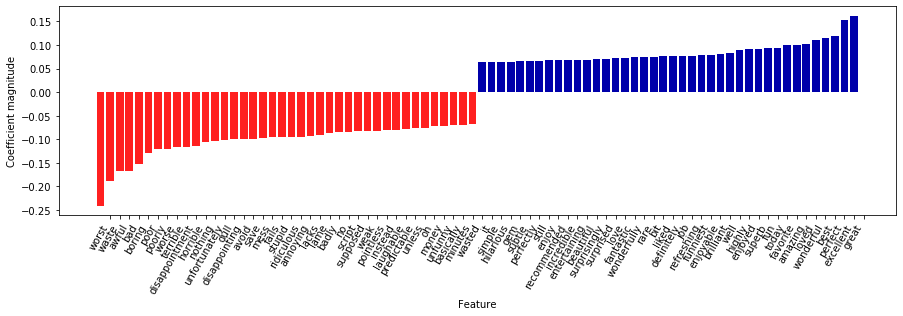

In [27]:
# Visualize coefficients learned by model with tf-idf features
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_,
                                     feature_names, n_top_features=40)

# https://github.com/amueller/mglearn/blob/master/mglearn/tools.py

In [28]:
# Using n-grams
print(bards_words)

# Default is creating unigrams
vect = CountVectorizer(ngram_range=(1, 1))
vect.fit(bards_words)
vocab = vect.vocabulary_
print('Vocabulary length: {}'.format(len(vocab)))
print('Vocabulary: {}'.format(vect.get_feature_names()))

['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']
Vocabulary length: 13
Vocabulary: ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [29]:
# Create Only bigrams
vect = CountVectorizer(ngram_range=(2, 2))
vect.fit(bards_words)
vocab = vect.vocabulary_
feature_names = vect.get_feature_names()
print('Vocab length: {}'.format(len(vocab)))
print('Vocab: {}'.format(feature_names))

Vocab length: 14
Vocab: ['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [30]:
# More specific features (no common bigrams)
print(vect.transform(bards_words).toarray())

[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [31]:
# Unigrams, bigrams and trigrams
vect = CountVectorizer(ngram_range=(1, 3))
vect.fit(bards_words)
vocab = vect.vocabulary_
feature_names = vect.get_feature_names()
print('Vocab length: {}'.format(len(vocab)))
print('Vocab: {}'.format(feature_names))

Vocab length: 39
Vocab: ['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


#### Normalization:
1. Stemming.
2. Lemmatization.

In [32]:
import spacy
import nltk
import re
from sklearn.model_selection import StratifiedShuffleSplit

In [33]:
# Load spacy English language models
en_nlp = spacy.load('en')

# Nltk Porter Stemmer
stemmer = nltk.stem.PorterStemmer()

# Function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    
    # print lemmas found by spacy
    print('Lemmatization:')
    print([token.lemma_ for token in doc_spacy])
    
    # print tokens found by Porter stemmer
    print('Stemming:')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])
    
compare_normalization(u"Our meeting today was worse than yesterday, "
                      "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [34]:
compare_normalization("Happy families are all alike; every unhappy family is unhappy in its own way."
                     "Everything was in confusion in the Oblonskys' house. ")

Lemmatization:
['happy', 'family', 'be', 'all', 'alike', ';', 'every', 'unhappy', 'family', 'be', 'unhappy', 'in', '-PRON-', 'own', 'way', '.', 'Everything', 'be', 'in', 'confusion', 'in', 'the', 'Oblonskys', "'", 'house', '.']
Stemming:
['happi', 'famili', 'are', 'all', 'alik', ';', 'everi', 'unhappi', 'famili', 'is', 'unhappi', 'in', 'it', 'own', 'way', '.', 'everyth', 'wa', 'in', 'confus', 'in', 'the', 'oblonski', "'", 'hous', '.']


In [35]:
# Specify tokenizer for CountVectorizer (parameter of the same name)
# New tokenizer: default regexp tokenizer + lemmatization from spacy
# ==> replace spacy tokenizer with regexp-based tokenization

# Default regexp from CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b') # regexp object with findall method

# Load spacy language model
en_nlp = spacy.load('en', disable=['parser', 'ner']) # spacy.lang.en.English

# Save old tokenizer
old_tokenizer = en_nlp.tokenizer # spacy.tokenizer.Tokenizer

# Replace tokenizer with regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# Custom tokenizer
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# Count vectorizer with custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

# Transform train data
X_train_lemma = lemma_vect.fit_transform(text_train)
print(X_train_lemma.shape)

# Standard Count vectorizer
vect = CountVectorizer(min_df=5)
vect.fit(text_train)
X_train = vect.transform(text_train)
print(X_train.shape)

# Lemmatization reduced number of features

(25000, 21571)
(25000, 27271)


In [36]:
# Check scores
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# 1% for training
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(solver='saga', max_iter=100000), param_grid, cv=cv)

# Standard CountVectorizer
grid.fit(X_train, y_train)
print('Best CV score (CountVectorizer): {:.3f}'.format(grid.best_score_))

# With lemmatization
grid.fit(X_train_lemma, y_train)
print('Best CV score with lemmatization: {:.3f}'.format(grid.best_score_))

# Performance improved with lemmatization

Best CV score (CountVectorizer): 0.723
Best CV score with lemmatization: 0.735


## Topic modeling

**Topic modeling** - task of assigning each document to one or multiple topics, usually without supervision.

If each document is assigned a single topic - the task of **clustering the documents**.

If each document can have more than one topic - the task of **decomposition.** Each component corresponds to 1 topic. Coefficients of components in the document representation - show how strongly document is related to topics.

### Latent Dirichlet Allocation (LDA)

Decomposition method.

**Intuition**: find groups of words (topics) that appear together frequently.

**Assumption**: each document can be understood as a mixture of a subset of the topics.

**Notes**:
1. Topic may not have semantic meaning.
2. It is better to remove common words as they might dominate the analysis.
3. Topics don’t have an inherent ordering.
4. Changing the number of topics will change all topics.
5. Changing random_state may lead to different outcomes.
6. Topics produced by the LDA.transform method can be used as compact representation for supervised learning.

In [37]:
from sklearn.decomposition import LatentDirichletAllocation

# Limit vocabulary to 10000 most frequent words
# Ignore words that appear in at least 15% of documents
vect = CountVectorizer(max_features=10000, max_df=0.15)
X = vect.fit_transform(text_train)

In [38]:
# Extract 10 topics
lda = LatentDirichletAllocation(n_components=10, learning_method='batch',
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(X)

In [39]:
# Components_ attribute stores how important each word is for each topic
# (n_topics, n_words)
print(lda.components_.shape)

# Each document is represented by 10 components - 1 for each topic
print(document_topics.shape)
print(type(document_topics))

(10, 10000)
(25000, 10)
<class 'numpy.ndarray'>


In [40]:
# Look at the most important words for each topic
# Each topic - row in lda.components_

# Sort features for each topic
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get feature names
feature_names = np.array(vect.get_feature_names())

# https://github.com/amueller/mglearn/blob/master/mglearn/tools.py
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [41]:
# Example, inspect topic 5
horror = np.argsort(document_topics[:, 5])[::-1] # indices of sorted reviews belonging to 5th topic
print(horror.shape, '\n')
# Print reviews related to horror topic
for i in horror[:3]:
    print(b'.'.join(text_train[i].split(b'.')[:2]) + b'.', '\n')

(25000,) 

b"I've seen plenty of Sci-Fi Channel Original movies ever since I started watching them back in 2002 (My first one was Sabretooth - which actually is one of the more entertaining Sci-Fi Channel features in my opinion). Their quality varies." 

b'I don\'t know whether to recommend this movie to the fans of " Tetsuo " or not . Why " Tetsuo " ? Because you can easily label some things about this movie as a very obvious " Tetsuo " rip - off .' 

b"I really tried to like this movie but in the end it just didn't work for me. I have seen most of Kitamura's output and have found it to be very variable." 



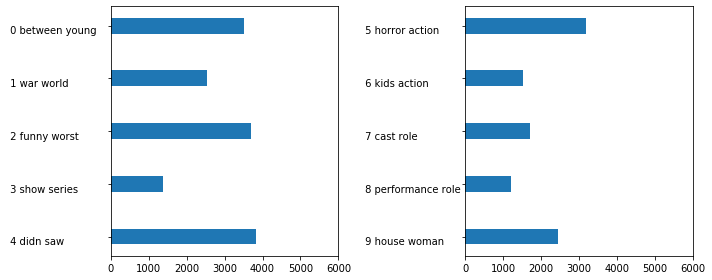

In [42]:
# How much weight each topic gets overall in corpus
# Sum document_topics over all reviews

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Name each topic by 2 most common words
topic_names = ['{:>2} '.format(i) + ' '.join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

for col in [0, 1]:
    start = col * 5
    end = (col + 1) * 5
    ax[col].barh(np.arange(5), np.sum(document_topics, axis=0)[start:end], height=0.3)
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 6000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=100)
plt.tight_layout()